# MNIST with TensorFlow

Simple Softmax classifier

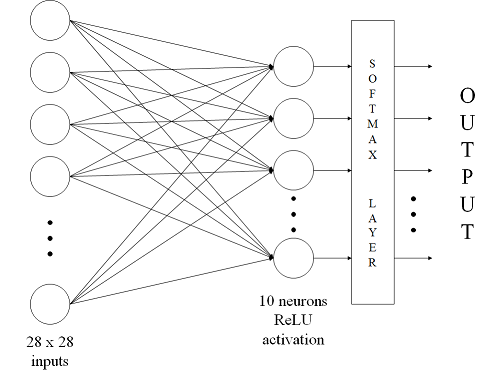

In [78]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#import the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


In [2]:
#define variables and placeholders for the ssoftmax classsifier
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
W = tf.Variable(tf.random_normal([784, 10])*0.01, name='W')
b = tf.Variable(tf.zeros([1, 10]))

In [10]:
#output of the softmax classifier
Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b)

#label vectors for the MNIST data
Y_ = tf.placeholder(tf.float32, [None, 10])

#loss
loss = tf.reduce_mean(-tf.reduce_sum(Y_*tf.log(Y), reduction_indices=[1]))

#accuracy evaluation
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#correct labels for the training data, this would help later in understanding what errors our model is making
labels = tf.argmax(Y_,1) 

In [11]:
#setup gradient descent optimzer
optimizer = tf.train.GradientDescentOptimizer(0.1)
train_step = optimizer.minimize(loss)

In [12]:
#start a session and train
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(10000):
    batch_X, batch_y = mnist.train.next_batch(100)
    train_dict = {X: batch_X , Y_: batch_y}
    
    sess.run(train_step, feed_dict=train_dict)
    
    a,c = sess.run([accuracy, loss], feed_dict=train_dict)

is_correct, labels = sess.run([is_correct, labels], feed_dict={X:mnist.train.images, Y_:mnist.train.labels})
print ("Accuracy of the model is: ", a)   #print accuracy of the model

Accuracy of the model is:  0.94


So the accuracy for our softmax classifier is 94%, which is quite good given the simplisitic nature of our model.

# Bonus
Now, we will visualize the trained weights, to gain an insight into how the network is  predicting the digits and investigate if there are specific classes which are causing more erroneous predictions as compared to others.

In [13]:
#get list of trainable variables, it should consist of 2 objects, one for the weights and one for biases
tf.trainable_variables()

[<tf.Variable 'W:0' shape=(784, 10) dtype=float32_ref>,
 <tf.Variable 'Variable:0' shape=(1, 10) dtype=float32_ref>]

In [15]:
#store weight matrix into a variable
weight_array = sess.run(tf.trainable_variables()[0])

In [16]:
#verify the shape of the weight matrix
weight_array.shape

(784, 10)

In [18]:
#convert the weight matrix into a collection of ten 28x28 matrices, each corresponding to one of the ten output units/classes/digits
new_weight = np.reshape(weight_array, [28,28,10])
new_weight.shape

(28, 28, 10)

Let us plot a histogram for any one of the 10 weight matrices to look at its overall distribution

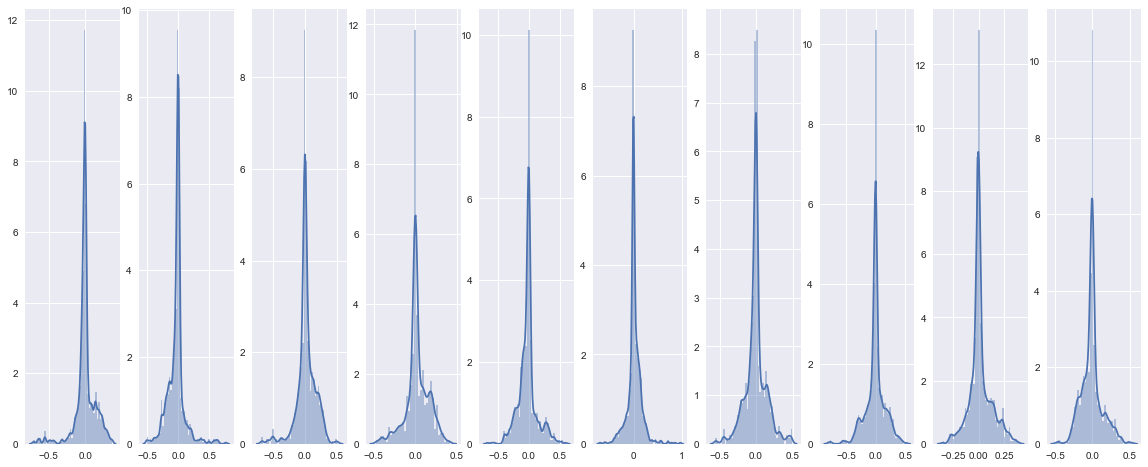

In [69]:
#histogram for all weight matrices. We need to flatten the matrices before plotting the histogram
f, a = plt.subplots(1,10, figsize=(20,8))

for i in range(10):
    sns.distplot(np.reshape(new_weight[:,:,i], [1, -1]), ax = a[i])

All the weights are normally distributed about zero. Since each pixel has one weight value associated with it per digit, it is same to assume that the pixels which frequently light up for a given digit should have high value for the weight associated with that digit.

Similarly, a pixel which barely ever lights up for a given digit should have a low value for the weight associated with the digit.''

Pixels in the background, which almost never light up for any of the images should have values lying close to zero, to which they were initialized to.

Let us plot the weight matrices for each of the digits as 28x28 images (heatmaps) and see if that is indeed true.

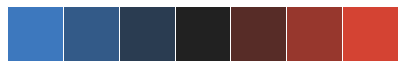

In [74]:
# set color map for the plot
cmap = sns.diverging_palette(250, 15, s = 80, n=7, center='dark', as_cmap=True )

#view color map (blue: low values, red: high values, black: values close to zero) 
sns.palplot(sns.diverging_palette(250, 15, s = 80, n=7, center='dark'))

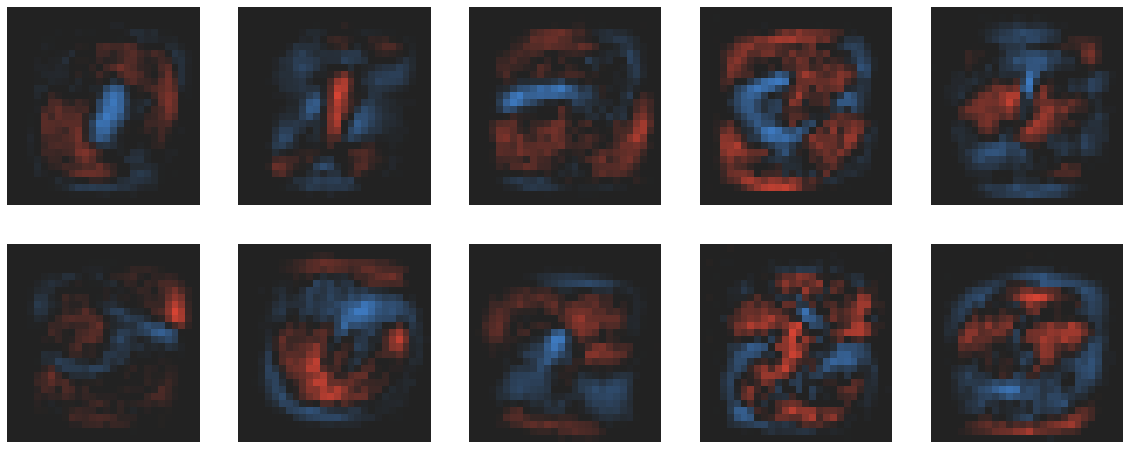

In [75]:
#plotting the heatmaps
f, a = plt.subplots(2, 5, figsize=(20,8))

for i in range(2):
    for j in range(5):
        sns.heatmap(new_weight[:,:,(i*5)+j], cbar=False, ax = a[i,j], xticklabels=False, yticklabels=False, cmap= cmap)


As we can see from the 10 heatmaps, high weight values (reds) form a pattern resembling the corresponding digit, low weights (blue) form the areas around them and the weights close to zero correspond to the background.

NOTE: The high weights (reds) should only form diffuse features unique to the corresponding digit. If they form a sharp and clear image of the digit, it would mean that they have overfitted to the training data and might not perform well when a slightly different test image is presented. Overfitting can occur because of the model itself or because of biased data (if the data has only one type of '3's, the model would tend to overfit and perform poorly in a real world scenario)

Now, let us check if any specific digit contributes more/less to the wrong predictions as compared others or is it rather evenly disrtributed.

In [37]:
#filter out all the incorrectly predicted cases
wrong_labels = labels[is_correct == False]

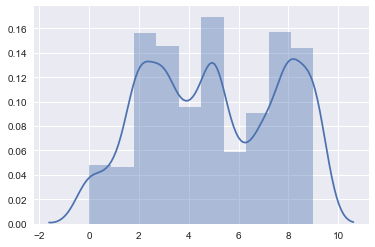

In [76]:
#plot the original labels of all the incorrectly predicted cases
a = sns.distplot(wrong_labels, bins = 10)

As can be seen from the distribution, digits 0,1 and 6 show particularly low error rates and almost all others show much higher error rates, with digits 5,3 and 8 being the highest. This could be because of the simpler shapes of some digits (1 and 0 for instance) as compared to others.

A big reason behind the model not showing much higher accuracy (~97%-99%) is the fact that we flatten the images into vectors before training. In the process, we lose out on a lot of the spatial information about each image and are not able to performm well on images having complex patterns.

Convolutional Neural Nets (CNNs) are much better at handling such tasks as they retain spatial information while training.

# ----------------------------------------------------END----------------------------------------------------